# CompKey

- |{s}| 种子关键词的搜索量
- |{sa}| 联合查询搜索量，种子关键词和对应的中介关键词一起出现的查询搜索
- 中介关键词的权重：$$w_a(k)=\frac{|\{sa\}|}{|\{s\}|}$$ 
- |{ka}| 竞争性关键词的词频（不含有种子关键词，但有中介关键词的搜索）
- |{a}| 所有中介关键词的搜索量
- 竞争性 Comp 测度的计算公式：$$Comp_s(k,s)=\frac{|\{ka\}|}{(|\{a\}|-|\{sa\}|)}$$
- 关键词 k 与种子关键词 s 的竞争性程度：$$Comp(k,s)=\sum_{i=1}^{m}{\{w_{a_i}(k)\times Comp_{a_i}(k,s)\}}$$

In [29]:
import jieba
import time

time_stats = {}

total_start_time = time.time()

# 关键词列表
dirty_seedwords = [
    "图片::", "手机::", "小说::", "视频::", "下载::", "大全::", "qq::", "电影::", "中国::", "世界::",
    # "重生::", "百度::", "官网::", "txt::", "英语::", "电视剧::", "游戏::", "查询::", "做法::", "倾城::"
]
# 加载自定义词典
jieba.load_userdict('../data/dictionary')
# 种子关键词列表
seedwords = [keyword[:-2] for keyword in dirty_seedwords]

# 种子关键词搜索条目输入文件路径
seed_words_query_file_path = '../data/processed/seed_words_query.train'

In [30]:
# 1. 加载停用词
stopwords_file = '../data/stop_words/merge_stopwords.txt'  # 停用词文件路径
stopwords = set()
with open(stopwords_file, 'r', encoding='utf-8') as file:
    for line in file:
        stopwords.add(line.strip())

In [31]:
# 创建一个字典，用于存储包含种子关键词的搜索记录数
s_query_volume = {keyword: 0 for keyword in seedwords}

# 统计种子关键词对应的搜索条目的数量
# 计算 s 的具体时间
with open(seed_words_query_file_path, 'r', encoding='utf-8') as input_data:
    s_start_time = time.time()
    current_seed_keyword = None
    for line in input_data:
        line = line.strip()
        # 读取到新的关键词
        if any(keyword == line for keyword in dirty_seedwords):
            # 重新赋值
            current_seed_keyword = line[:-2]
        else:
            # 统计包含种子关键词的搜索条目的数量
            s_query_volume[current_seed_keyword] += 1
    s_end_time = time.time()
    time_stats['s_time'] = s_end_time - s_start_time

s_query_volume

{'图片': 301220,
 '手机': 213088,
 '小说': 178465,
 '视频': 166847,
 '下载': 136512,
 '大全': 136302,
 'qq': 102172,
 '电影': 110291,
 '中国': 122861,
 '世界': 783827}

In [32]:
# 定义一个字典来存储每个词及其对应的分词结果
word_dict = {keyword: [] for keyword in seedwords}
# 创建一个字典，用于存储同时包含种子关键词和中介关键词的搜索记录数
mid_word_dict = {keyword: {} for keyword in seedwords}

# 读取种子关键词搜索条目文件，将搜索条目分词
with open(seed_words_query_file_path, 'r', encoding='utf-8') as train_data:
    # 当前处理的关键词
    current_seed_word = None
    # 逐行处理
    for line in train_data:
        line = line.strip()
        # 判断是否为新关键词行
        if any(keyword == line for keyword in dirty_seedwords):
            current_seed_word = line[:-2]  # 去掉冒号
        else:
            # 使用lcut分词，返回结果为列表形式
            seg_list = [word for word in jieba.lcut(line) if word != '']
            # 去掉与当前关键词相同的部分，同时删除出现在停用词列表中的词
            filtered_segs = [seg for seg in seg_list if seg != current_seed_word and seg not in stopwords]
            # 将分词的结果存储到 word_dict 中
            word_dict[current_seed_word].extend(filtered_segs)

    # 计算sa
    sa_start_time = time.time()
    for keyword, seg_list in word_dict.items():
        for seg in seg_list:
            # 统计包含当前关键词和中介词的搜索记录数
            if seg in mid_word_dict[keyword]:
                mid_word_dict[keyword][seg]['freq'] += 1
            else:
                mid_word_dict[keyword][seg] = {'freq': 1, 'weight': 0}
    sa_end_time = time.time()
    time_stats['sa_time'] = sa_end_time - sa_start_time

    # 每个种子关键词下只选取数目最多的前20个作为中介关键词
    for keyword in mid_word_dict:
        sorted_mid_words = sorted(mid_word_dict[keyword].items(), key=lambda x: x[1]['freq'], reverse=True)
        mid_word_dict[keyword] = {mid_word: info for mid_word, info in sorted_mid_words[:20]}

    # 计算权重
    wight_start_time = time.time()
    for keyword in mid_word_dict:
        for mid_word in mid_word_dict[keyword]:
            # 计算权重
            mid_word_dict[keyword][mid_word]['weight'] = mid_word_dict[keyword][mid_word]['freq'] / s_query_volume[
                keyword]
    wight_end_time = time.time()
    time_stats['wight_time'] = wight_end_time - wight_start_time

mid_word_dict

{'图片': {'大全': {'freq': 32220, 'weight': 0.10696500896354824},
  '发型': {'freq': 5680, 'weight': 0.018856649624858907},
  '报价': {'freq': 4264, 'weight': 0.014155766549365912},
  '唯美': {'freq': 4170, 'weight': 0.013843702277405218},
  '价格': {'freq': 4013, 'weight': 0.013322488546577253},
  '搞笑': {'freq': 3684, 'weight': 0.012230263594714826},
  '2016': {'freq': 3676, 'weight': 0.012203704933271364},
  '手机': {'freq': 3325, 'weight': 0.011038443662439413},
  'qq': {'freq': 3305, 'weight': 0.010972047008830754},
  '动漫': {'freq': 3140, 'weight': 0.010424274616559325},
  '背景图片': {'freq': 2824, 'weight': 0.009375207489542526},
  '动态': {'freq': 2699, 'weight': 0.008960228404488414},
  '简笔画': {'freq': 2647, 'weight': 0.008787597105105903},
  '手抄报': {'freq': 2584, 'weight': 0.00857844764623863},
  '带字': {'freq': 2409, 'weight': 0.00799747692716287},
  '文字': {'freq': 2328, 'weight': 0.007728570480047806},
  '可爱': {'freq': 2325, 'weight': 0.007718610982006507},
  '女生': {'freq': 2284, 'weight': 0.007

In [33]:
# 中介关键词缓存
mid_word_dict = {'图片': {'大全': {'freq': 32220, 'weight': 0.10696500896354824},
                          '发型': {'freq': 5683, 'weight': 0.018866609122900207},
                          '报价': {'freq': 4264, 'weight': 0.014155766549365912},
                          '唯美': {'freq': 4170, 'weight': 0.013843702277405218},
                          '价格': {'freq': 4013, 'weight': 0.013322488546577253},
                          '搞笑': {'freq': 3684, 'weight': 0.012230263594714826},
                          '2016': {'freq': 3676, 'weight': 0.012203704933271364},
                          '手机': {'freq': 3325, 'weight': 0.011038443662439413},
                          'qq': {'freq': 3305, 'weight': 0.010972047008830754},
                          '动漫': {'freq': 3145, 'weight': 0.01044087377996149},
                          '背景图片': {'freq': 2824, 'weight': 0.009375207489542526},
                          '动态': {'freq': 2699, 'weight': 0.008960228404488414},
                          '简笔画': {'freq': 2647, 'weight': 0.008787597105105903},
                          '手抄报': {'freq': 2584, 'weight': 0.00857844764623863},
                          '带字': {'freq': 2405, 'weight': 0.00798419759644114},
                          '文字': {'freq': 2328, 'weight': 0.007728570480047806},
                          '可爱': {'freq': 2325, 'weight': 0.007718610982006507},
                          '女生': {'freq': 2284, 'weight': 0.007582497842108757},
                          '头发': {'freq': 2256, 'weight': 0.007489542527056636},
                          '微信': {'freq': 2250, 'weight': 0.007469623530974039}},
                 '手机': {'手机版': {'freq': 23430, 'weight': 0.10995457275867247},
                          '下载': {'freq': 11998, 'weight': 0.05630537618261},
                          'qq': {'freq': 11859, 'weight': 0.05565306352305151},
                          '苹果': {'freq': 10207, 'weight': 0.047900397957651296},
                          '软件': {'freq': 7257, 'weight': 0.03405635230515092},
                          '手机号': {'freq': 5104, 'weight': 0.023952545427241328},
                          '华为': {'freq': 5056, 'weight': 0.023727286379336236},
                          '手机游戏': {'freq': 4336, 'weight': 0.020348400660759873},
                          '设置': {'freq': 4229, 'weight': 0.019846260699804774},
                          '壁纸': {'freq': 4226, 'weight': 0.01983218200931071},
                          '视频': {'freq': 3812, 'weight': 0.017889322721129298},
                          '小米': {'freq': 3428, 'weight': 0.016087250337888572},
                          '三星': {'freq': 3365, 'weight': 0.01579159783751314},
                          '图片': {'freq': 3151, 'weight': 0.014787317915602944},
                          '手机号码': {'freq': 3144, 'weight': 0.014754467637783451},
                          '世界': {'freq': 3131, 'weight': 0.014693459978975823},
                          '手机卡': {'freq': 3112, 'weight': 0.014604294939180057},
                          '密码': {'freq': 3035, 'weight': 0.01424294188316564},
                          '在线': {'freq': 2832, 'weight': 0.01329028382640036},
                          '游戏': {'freq': 2831, 'weight': 0.013285590929569005}},
                 '小说': {'穿越': {'freq': 8149, 'weight': 0.045661614322135995},
                          '好看': {'freq': 6077, 'weight': 0.03405149469083574},
                          '类似': {'freq': 5816, 'weight': 0.03258902305774242},
                          '排行榜': {'freq': 5233, 'weight': 0.029322276076541618},
                          '耽美': {'freq': 5215, 'weight': 0.029221415963914494},
                          '阅读': {'freq': 4714, 'weight': 0.026414142829126158},
                          '重生': {'freq': 4598, 'weight': 0.025764155436640238},
                          '主角': {'freq': 4567, 'weight': 0.025590451909337966},
                          '下载': {'freq': 4477, 'weight': 0.025086151346202335},
                          '小说网': {'freq': 4410, 'weight': 0.02471072759364581},
                          '倾城': {'freq': 4123, 'weight': 0.023102569131202195},
                          '女主': {'freq': 3927, 'weight': 0.022004314571484603},
                          '微微一笑': {'freq': 3906, 'weight': 0.02188664444008629},
                          '免费': {'freq': 3853, 'weight': 0.02158966744179531},
                          '都市': {'freq': 3788, 'weight': 0.02122545036841958},
                          '完结': {'freq': 3602, 'weight': 0.020183229204605944},
                          '同人小说': {'freq': 3280, 'weight': 0.018378953856498473},
                          '玄幻': {'freq': 2653, 'weight': 0.01486565993332026},
                          '言情小说': {'freq': 2646, 'weight': 0.014826436556187489},
                          'txt': {'freq': 2465, 'weight': 0.013812232090325834}},
                 '视频': {'教学': {'freq': 5211, 'weight': 0.031232206752294017},
                          '在线': {'freq': 4943, 'weight': 0.029625944727804516},
                          '观看': {'freq': 4914, 'weight': 0.02945213279231871},
                          '大全': {'freq': 4547, 'weight': 0.027252512781170773},
                          '手机': {'freq': 3867, 'weight': 0.023176922569779497},
                          '腾讯': {'freq': 3302, 'weight': 0.019790586585314688},
                          '在线视频': {'freq': 3283, 'weight': 0.019676709799996403},
                          '搞笑': {'freq': 3092, 'weight': 0.018531948431796796},
                          '舞蹈': {'freq': 3026, 'weight': 0.018136376440691174},
                          '下载': {'freq': 2998, 'weight': 0.017968558020222118},
                          '视频教程': {'freq': 2948, 'weight': 0.017668882269384525},
                          '2016': {'freq': 2589, 'weight': 0.015517210378370602},
                          '直播': {'freq': 2424, 'weight': 0.014528280400606544},
                          '青青草': {'freq': 2408, 'weight': 0.014432384160338515},
                          '王者荣耀': {'freq': 2386, 'weight': 0.014300526829969972},
                          '吻戏': {'freq': 2355, 'weight': 0.014114727864450664},
                          '超碰': {'freq': 2160, 'weight': 0.012945992436184049},
                          '微信': {'freq': 2147, 'weight': 0.012868076740966275},
                          '马蓉': {'freq': 2007, 'weight': 0.012028984638621011},
                          '播放': {'freq': 1921, 'weight': 0.01151354234718035}},
                 '下载': {'txt': {'freq': 34759, 'weight': 0.2546223042662916},
                          '全集': {'freq': 7498, 'weight': 0.0549255743084857},
                          '手机': {'freq': 7157, 'weight': 0.05242762541022035},
                          '手机版': {'freq': 4779, 'weight': 0.03500791139240506},
                          '软件': {'freq': 4531, 'weight': 0.03319122128457572},
                          '免费': {'freq': 4309, 'weight': 0.031564990623534926},
                          '游戏': {'freq': 4085, 'weight': 0.029924109235818095},
                          '小说': {'freq': 3821, 'weight': 0.027990213314580403},
                          'qq': {'freq': 3255, 'weight': 0.023844057665260196},
                          '官方': {'freq': 3040, 'weight': 0.02226910454758556},
                          '视频': {'freq': 3000, 'weight': 0.021976090014064698},
                          'app': {'freq': 2862, 'weight': 0.020965189873417722},
                          '迅雷': {'freq': 2379, 'weight': 0.017427039381153305},
                          '下载安装': {'freq': 2307, 'weight': 0.016899613220815752},
                          '百度云': {'freq': 2273, 'weight': 0.01665055086732302},
                          '世界': {'freq': 2192, 'weight': 0.016057196436943273},
                          '重生': {'freq': 2007, 'weight': 0.014702004219409284},
                          '版': {'freq': 1938, 'weight': 0.014196554149085794},
                          '网': {'freq': 1854, 'weight': 0.013581223628691984},
                          '优酷': {'freq': 1795, 'weight': 0.013149027191748711}},
                 '大全': {'图片': {'freq': 31364, 'weight': 0.2301066748837141},
                          '做法': {'freq': 13030, 'weight': 0.09559654297075612},
                          '名字': {'freq': 5492, 'weight': 0.04029287904799636},
                          '视频': {'freq': 5099, 'weight': 0.03740957579492597},
                          '电影': {'freq': 3526, 'weight': 0.025869026133145515},
                          '游戏': {'freq': 3280, 'weight': 0.024064210356414432},
                          '歌曲': {'freq': 3113, 'weight': 0.02283898989009699},
                          'qq': {'freq': 2983, 'weight': 0.0218852254552391},
                          '电视剧': {'freq': 2981, 'weight': 0.02187055215624129},
                          '说': {'freq': 2961, 'weight': 0.02172381916626315},
                          '2016': {'freq': 2588, 'weight': 0.0189872489031709},
                          '全集': {'freq': 2423, 'weight': 0.01777670173585127},
                          '图案': {'freq': 2306, 'weight': 0.01691831374447917},
                          '字': {'freq': 2152, 'weight': 0.01578846972164752},
                          '搞笑': {'freq': 1962, 'weight': 0.014394506316855219},
                          '旅游景点': {'freq': 1834, 'weight': 0.013455415180995143},
                          '成语': {'freq': 1827, 'weight': 0.013404058634502796},
                          '漫画': {'freq': 1797, 'weight': 0.01318395914953559},
                          '手抄报': {'freq': 1605, 'weight': 0.011775322445745477},
                          '图解': {'freq': 1584, 'weight': 0.011621252806268433}},
                 'qq': {'头像': {'freq': 10565, 'weight': 0.10340406373566144},
                        '手机': {'freq': 10062, 'weight': 0.09848099283561054},
                        '空间': {'freq': 6803, 'weight': 0.06658379986689113},
                        '号': {'freq': 4068, 'weight': 0.039815213561445406},
                        '飞车': {'freq': 3941, 'weight': 0.038572211564812275},
                        '说': {'freq': 3866, 'weight': 0.03783815526758799},
                        '邮箱': {'freq': 3712, 'weight': 0.03633089300395412},
                        '音乐': {'freq': 3222, 'weight': 0.03153505852875543},
                        '网名': {'freq': 3127, 'weight': 0.030605253885604665},
                        '下载': {'freq': 3109, 'weight': 0.030429080374270837},
                        '好友': {'freq': 3063, 'weight': 0.02997885917863994},
                        '群': {'freq': 2997, 'weight': 0.029332889637082568},
                        '大全': {'freq': 2940, 'weight': 0.02877500685119211},
                        '女生': {'freq': 2643, 'weight': 0.025868143914183926},
                        '男生': {'freq': 2489, 'weight': 0.024360881650550052},
                        '图片': {'freq': 2164, 'weight': 0.021179971029244803},
                        '密码': {'freq': 2045, 'weight': 0.020015268370982265},
                        '浏览器': {'freq': 2029, 'weight': 0.019858669694241084},
                        '中心': {'freq': 1989, 'weight': 0.01946717300238813},
                        '会员': {'freq': 1976, 'weight': 0.01933993657753592}},
                 '电影': {'韩国': {'freq': 5689, 'weight': 0.05158172471008514},
                          '电影网': {'freq': 4369, 'weight': 0.03961338640505572},
                          '完整版': {'freq': 4210, 'weight': 0.038171745654677174},
                          '观看': {'freq': 3826, 'weight': 0.034690047238668614},
                          '全集': {'freq': 3742, 'weight': 0.03392842571016674},
                          '在线': {'freq': 3577, 'weight': 0.032432383422038066},
                          '大全': {'freq': 3574, 'weight': 0.032405182653162994},
                          '手机': {'freq': 3065, 'weight': 0.027790118867359985},
                          '电影院': {'freq': 2617, 'weight': 0.023728137382016665},
                          '好看': {'freq': 2392, 'weight': 0.02168807971638665},
                          '微微一笑': {'freq': 2057, 'weight': 0.018650660525337516},
                          '倾城': {'freq': 2032, 'weight': 0.018423987451378625},
                          '天堂': {'freq': 1797, 'weight': 0.016293260556165055},
                          '神马': {'freq': 1731, 'weight': 0.015694843640913583},
                          '2016': {'freq': 1643, 'weight': 0.014896954420578288},
                          '下载': {'freq': 1512, 'weight': 0.013709187513033702},
                          '最新': {'freq': 1320, 'weight': 0.011968338305029422},
                          '日本': {'freq': 1319, 'weight': 0.011959271382071066},
                          '爱情': {'freq': 1297, 'weight': 0.011759799076987243},
                          '美国': {'freq': 1286, 'weight': 0.011660062924445332}},
                 '中国': {'中国女排': {'freq': 5534, 'weight': 0.04504277191297482},
                          '新': {'freq': 4861, 'weight': 0.039565036911631844},
                          '歌声': {'freq': 4556, 'weight': 0.03708255671042886},
                          '中国移动': {'freq': 4206, 'weight': 0.03423380893855658},
                          '2016': {'freq': 3456, 'weight': 0.0281293494274017},
                          '声音': {'freq': 2800, 'weight': 0.022789982174978227},
                          '地图': {'freq': 2724, 'weight': 0.022171396944514532},
                          '中国银行': {'freq': 2590, 'weight': 0.02108073351185486},
                          '排名': {'freq': 2352, 'weight': 0.01914358502698171},
                          '关系': {'freq': 2241, 'weight': 0.01824012501933079},
                          '中国式': {'freq': 2086, 'weight': 0.01697853672035878},
                          '官网': {'freq': 2054, 'weight': 0.016718079781216172},
                          '奥运会': {'freq': 1908, 'weight': 0.01552974499637802},
                          '视频': {'freq': 1797, 'weight': 0.014626284988727098},
                          '营业厅': {'freq': 1713, 'weight': 0.013942585523477751},
                          '图片': {'freq': 1658, 'weight': 0.013494925159326394},
                          '里': {'freq': 1629, 'weight': 0.013258886058228404},
                          '年': {'freq': 1535, 'weight': 0.012493793799496992},
                          '约': {'freq': 1530, 'weight': 0.01245309740275596},
                          '十大': {'freq': 1526, 'weight': 0.012420540285363133}},
                 '世界': {'重生': {'freq': 77009, 'weight': 0.09824744490812386},
                          '官网': {'freq': 74170, 'weight': 0.094625472202412},
                          '电视剧': {'freq': 73275, 'weight': 0.09348363860902979},
                          'txt': {'freq': 72677, 'weight': 0.09272071515780905},
                          '倾城': {'freq': 69777, 'weight': 0.0890209191569058},
                          '英语': {'freq': 66114, 'weight': 0.08434769407024764},
                          '游戏': {'freq': 63903, 'weight': 0.08152691856749002},
                          '查询': {'freq': 63102, 'weight': 0.08050500939620606},
                          '微微一笑': {'freq': 62074, 'weight': 0.07919349550347207},
                          '做法': {'freq': 60047, 'weight': 0.07660746567801313},
                          '下载': {'freq': 50615, 'weight': 0.0645741981330064},
                          '百度云': {'freq': 42392, 'weight': 0.054083362782858975},
                          '百度': {'freq': 30187, 'weight': 0.038512324785954045},
                          '大全': {'freq': 21605, 'weight': 0.02756348020672929},
                          '全集': {'freq': 13902, 'weight': 0.017736056553295562},
                          '小说': {'freq': 13624, 'weight': 0.01738138645389863},
                          '说': {'freq': 13475, 'weight': 0.017191293486955667},
                          '快递单号': {'freq': 9292, 'weight': 0.011854656703583826},
                          '手机': {'freq': 8405, 'weight': 0.010723029443997209},
                          '资源': {'freq': 7731, 'weight': 0.009863145821718313}}}

## 确定竞争性关键字集合

In [34]:
temp = mid_word_dict
mid_word_dict = {}
for k, v in temp.items():
    mid_word_dict[k] = []
    for k1, v1 in v.items():
        mid_word_dict[k].append({'keyword': k1, 'freq': v1['freq'], 'weight': v1['weight']})
mid_word_dict

{'图片': [{'keyword': '大全', 'freq': 32220, 'weight': 0.10696500896354824},
  {'keyword': '发型', 'freq': 5683, 'weight': 0.018866609122900207},
  {'keyword': '报价', 'freq': 4264, 'weight': 0.014155766549365912},
  {'keyword': '唯美', 'freq': 4170, 'weight': 0.013843702277405218},
  {'keyword': '价格', 'freq': 4013, 'weight': 0.013322488546577253},
  {'keyword': '搞笑', 'freq': 3684, 'weight': 0.012230263594714826},
  {'keyword': '2016', 'freq': 3676, 'weight': 0.012203704933271364},
  {'keyword': '手机', 'freq': 3325, 'weight': 0.011038443662439413},
  {'keyword': 'qq', 'freq': 3305, 'weight': 0.010972047008830754},
  {'keyword': '动漫', 'freq': 3145, 'weight': 0.01044087377996149},
  {'keyword': '背景图片', 'freq': 2824, 'weight': 0.009375207489542526},
  {'keyword': '动态', 'freq': 2699, 'weight': 0.008960228404488414},
  {'keyword': '简笔画', 'freq': 2647, 'weight': 0.008787597105105903},
  {'keyword': '手抄报', 'freq': 2584, 'weight': 0.00857844764623863},
  {'keyword': '带字', 'freq': 2405, 'weight': 0.007984

In [35]:

mid_word_dict = {key: mid_word_dict[key] for key in seedwords}

# 如果中介关键词包含种子关键词子串，则删除
for seedword in seedwords:
    mid_word_dict[seedword] = [midkey for midkey in mid_word_dict[seedword] if seedword not in midkey['keyword']]

# 只要前10个中介关键词
mid_word_dict = {key: mid_word_dict[key][:10] for key in mid_word_dict}

mid_word_dict

{'图片': [{'keyword': '大全', 'freq': 32220, 'weight': 0.10696500896354824},
  {'keyword': '发型', 'freq': 5683, 'weight': 0.018866609122900207},
  {'keyword': '报价', 'freq': 4264, 'weight': 0.014155766549365912},
  {'keyword': '唯美', 'freq': 4170, 'weight': 0.013843702277405218},
  {'keyword': '价格', 'freq': 4013, 'weight': 0.013322488546577253},
  {'keyword': '搞笑', 'freq': 3684, 'weight': 0.012230263594714826},
  {'keyword': '2016', 'freq': 3676, 'weight': 0.012203704933271364},
  {'keyword': '手机', 'freq': 3325, 'weight': 0.011038443662439413},
  {'keyword': 'qq', 'freq': 3305, 'weight': 0.010972047008830754},
  {'keyword': '动漫', 'freq': 3145, 'weight': 0.01044087377996149}],
 '手机': [{'keyword': '下载', 'freq': 11998, 'weight': 0.05630537618261},
  {'keyword': 'qq', 'freq': 11859, 'weight': 0.05565306352305151},
  {'keyword': '苹果', 'freq': 10207, 'weight': 0.047900397957651296},
  {'keyword': '软件', 'freq': 7257, 'weight': 0.03405635230515092},
  {'keyword': '华为', 'freq': 5056, 'weight': 0.02372

In [36]:
# 筛选出不含种子关键词，但含有其中介关键词的搜索数据，存储在相应的文件中
def comkey_words_file(seedword: str):
    query_data = open('../data/temp/cleaned.train', 'r', encoding='utf-8')
    filename = ('../data/temp/compkey_') + seedword
    result_data = open(filename, 'w', encoding='utf-8')
    for line in query_data:
        if seedword not in line:
            for midkeyword in mid_word_dict[seedword]:
                if midkeyword['keyword'] in line:
                    cut_line: list[str] = jieba.lcut(line)
                    # 写入文件，词与词之间用\t分隔
                    for word in cut_line:
                        result_data.write(word + '\t')
                    result_data.write('\n')
                    # result_data.write(line)
                    break
    query_data.close()
    result_data.close()


for seedword in seedwords:
    print(seedword)
    comkey_words_file(seedword)

图片
手机
小说
视频
下载
大全
qq
电影
中国
世界


In [37]:
from collections import Counter


def stop_words_filter(word_list):
    word_cleaned = []
    for word in word_list:
        if word not in stopwords and word.strip() != '':
            word_cleaned.append(word)
    return word_cleaned


import jieba

jieba.load_userdict('../data/dict/流行网络小说词库.txt')
jieba.load_userdict('../data/dict/网络流行新词【官方推荐】.txt')

ka_list = []
comp_list = []


# 从包含中介词的文件中提取与给定种子词相关的关键词
def get_compkey_words(seedword: str):
    ka_list_line = []
    comp_list_line = []
    for mid_word in mid_word_dict[seedword]:
        compkey_data = open('../data/temp/compkey_' + seedword, 'r', encoding='utf-8')
        # 将包含中介关键词的搜索数据进行分词
        compkey_query_list = []
        for line in compkey_data:
            if mid_word['keyword'] in line:
                # line = line.strip()
                # word_seg = jieba.lcut(line)
                word_seg = line.split('\t')
                compkey_query_list.extend(word_seg)
        compkey_query_list = stop_words_filter(compkey_query_list)
        count_result = Counter(compkey_query_list)
        # 打印出现频率最高的三个词
        is_append = False
        for key, val in count_result.most_common(3):
            if key != mid_word['keyword']:
                # 只把第一个词加入到ka_list_line和comp_list_line中
                if not is_append:
                    ka_list_line.append(val)
                    comp_list_line.append(key)
                    is_append = True
                print(key, val, end='  ')
        print()
        compkey_data.close()
    ka_list.append(ka_list_line)
    comp_list.append(comp_list_line)


ka_start_time = time.time()
for seedword in seedwords:
    print('\n' + seedword + ':\n')
    get_compkey_words(seedword)
ka_end_time = time.time()
time_stats['ka_time'] = ka_end_time - ka_start_time


图片:

做法 11982  名字 5243  
适合 2989  男生 2007  
2016 1183  款 1159  
句子 1495  女生 855  
价格表 8434  香烟 1775  
视频 3059  大全 1593  
年 32665  月 7075  
手机版 23363  下载 12015  
头像 10427  手机 9680  
头像 3191  日本 2289  

手机:

txt 34782  全集 7514  
头像 10393  空间 5855  
6s 2825  钱 2492  
下载 3805  免费 1359  
荣耀 5226  p9 2579  
路由器 2824  电脑 1455  
高清 1021  图片 842  
教学 5205  观看 4749  
官网 1194  note 962  
note7 1889  s7 1725  

小说:

穿越火线 6995  穿越之 5153  
电影 2124  电视剧 1583  
文 753  电影 753  
2016 3776  前十名 2852  
漫画 1153  文 1014  
全文 22595  免费 13154  
重生之 25049  txt 3404  
女主角 3795  男主角 1584  
txt 33393  全集 7353  
微微一笑 46007  电视剧 9265  

视频:

设计 832  教学计划 565  
观看 17386  阅读 4895  
在线 17301  电影 3568  
图片 31029  做法 12061  
手机版 22953  下载 11667  
游戏 1020  qq 770  
图片 3586  大全 1640  
教学 529  幼儿 241  
txt 34854  全集 7517  
年 32624  月 7049  

下载:

重生之 1205  微盘 1187  
电视剧 5396  漫画 3905  
手机版 18641  qq 11112  
世界 2289  饥荒 1019  
手机 5811  手机软件 1866  
阅读 14470  全文 8616  
手机游戏 4107  大全 4030  
穿越 6817  类似 5832  
头像 10572  手机 963

In [38]:
ka_list

[[11982, 2989, 1183, 1495, 8434, 3059, 32665, 23363, 10427, 3191],
 [34782, 10393, 2825, 3805, 5226, 2824, 1021, 5205, 1194, 1889],
 [6995, 2124, 753, 3776, 1153, 22595, 25049, 3795, 33393, 46007],
 [832, 17386, 17301, 31029, 22953, 1020, 3586, 529, 34854, 32624],
 [1205, 5396, 18641, 2289, 5811, 14470, 4107, 6817, 10572, 2125],
 [5512, 4265, 1955, 5128, 5657, 4674, 1268, 10388, 8809, 158693],
 [4704, 22183, 2053, 16373, 2050, 159369, 898, 3271, 2185, 34848],
 [874, 1010, 18237, 7883, 18819, 31019, 22910, 5239, 47855, 47932],
 [28837, 456, 32451, 1421, 2220, 2688, 350, 3237, 5982, 5201],
 [25289, 3254, 8818, 34832, 49975, 12656, 4957, 9258, 49890, 12104]]

In [39]:
comp_list

[['做法', '适合', '2016', '句子', '价格表', '视频', '年', '手机版', '头像', '头像'],
 ['txt', '头像', '6s', '下载', '荣耀', '路由器', '高清', '教学', '官网', 'note7'],
 ['穿越火线', '电影', '文', '2016', '漫画', '全文', '重生之', '女主角', 'txt', '微微一笑'],
 ['设计', '观看', '在线', '图片', '手机版', '游戏', '图片', '教学', 'txt', '年'],
 ['重生之', '电视剧', '手机版', '世界', '手机', '阅读', '手机游戏', '穿越', '头像', '官方网站'],
 ['发型', '家常', '好听', '教学', '韩国', '下载', '下载', '头像', '倾城', '小说'],
 ['女生', '手机版', '个人空间', '查询', '侠盗', '小说', '163', '背景音乐', '女生', 'txt'],
 ['中国', '视频', '在线', '下载', '观看', '图片', '手机版', '小说', '倾城', '微微一笑'],
 ['最新', '新', '年', '没', '百度', '大学排名', '人物', '学院', '约', '教学'],
 ['重生之', '学院', '倾城', '下载', '微微一笑', '说', '下载', '快递单号', '倾城', '大全']]

In [40]:
# 缓存ka_list和comp_list
ka_list = [[12907, 3002, 1183, 1495, 8434, 3059, 32665, 23397, 10427, 3193],
           [34782, 10393, 2825, 3805, 5226, 1021, 2824, 5205, 1194, 1889],
           [6995, 2128, 756, 3776, 2053, 22595, 25052, 3795, 33393, 46657],
           [832, 17397, 17301, 31526, 22987, 1020, 3586, 529, 34854, 32624],
           [1205, 5397, 18670, 2291, 5809, 14470, 4107, 6890, 10572, 2125],
           [5512, 4265, 1958, 5128, 5657, 4677, 1268, 10388, 8809, 158449],
           [4737, 22212, 2053, 16373, 2050, 159125, 898, 3271, 2213, 34848],
           [874, 1011, 18237, 7888, 18837, 31518, 22944, 5221, 47856, 48585],
           [28837, 456, 32451, 1421, 2220, 2688, 350, 3226, 5982, 5201],
           [533, 2608, 5692, 86, 1683, 4619, 34410, 1000, 5737, 515]]

comp_list = [['做法', '适合', '2016', '句子', '价格表', '视频', '年', '手机版', '头像', '头像'],
             ['txt', '头像', '6s', '下载', '荣耀', '高清', '路由器', '教学', '官网', 'note7'],
             ['穿越火线', '电影', '文', '2016', '耽', '全文', '重生之', '女主角', 'txt', '微微一笑'],
             ['设计', '观看', '在线', '图片', '手机版', '游戏', '图片', '教学', 'txt', '年'],
             ['重生之', '电视剧', '手机版', '世界', '手机', '阅读', '手机游戏', '穿越', '头像', '官方网站'],
             ['发型', '家常', '好听', '教学', '韩国', '下载', '下载', '头像', '倾城', '小说'],
             ['女生', '手机版', '个人空间', '查询', '侠盗', '小说', '163', '背景音乐', '女生', 'txt'],
             ['中国', '视频', '在线', '下载', '观看', '图片', '手机版', '小说', '倾城', '微微一笑'],
             ['最新', '新', '年', '没', '百度', '大学排名', '人物', '学院', '约', '教学'],
             ['魔兽争霸', '月', '异界', '学', '幸福生活', '下载', 'txt', '告白', '奇迹', '游戏']]

In [41]:
# 将种子关键词和竞争词合并成一个字典
compkeywords = dict(zip(seedwords, comp_list))
compkeywords

{'图片': ['做法', '适合', '2016', '句子', '价格表', '视频', '年', '手机版', '头像', '头像'],
 '手机': ['txt', '头像', '6s', '下载', '荣耀', '高清', '路由器', '教学', '官网', 'note7'],
 '小说': ['穿越火线', '电影', '文', '2016', '耽', '全文', '重生之', '女主角', 'txt', '微微一笑'],
 '视频': ['设计', '观看', '在线', '图片', '手机版', '游戏', '图片', '教学', 'txt', '年'],
 '下载': ['重生之', '电视剧', '手机版', '世界', '手机', '阅读', '手机游戏', '穿越', '头像', '官方网站'],
 '大全': ['发型', '家常', '好听', '教学', '韩国', '下载', '下载', '头像', '倾城', '小说'],
 'qq': ['女生', '手机版', '个人空间', '查询', '侠盗', '小说', '163', '背景音乐', '女生', 'txt'],
 '电影': ['中国', '视频', '在线', '下载', '观看', '图片', '手机版', '小说', '倾城', '微微一笑'],
 '中国': ['最新', '新', '年', '没', '百度', '大学排名', '人物', '学院', '约', '教学'],
 '世界': ['魔兽争霸', '月', '异界', '学', '幸福生活', '下载', 'txt', '告白', '奇迹', '游戏']}

In [42]:
# 取出每个种子关键词的中介关键词的keyword，取成二维列表
midkeywords_list = []
for seedword in seedwords:
    midkeywords_list.append([midkey['keyword'] for midkey in mid_word_dict[seedword]])
midkeywords_list

[['大全', '发型', '报价', '唯美', '价格', '搞笑', '2016', '手机', 'qq', '动漫'],
 ['下载', 'qq', '苹果', '软件', '华为', '设置', '壁纸', '视频', '小米', '三星'],
 ['穿越', '好看', '类似', '排行榜', '耽美', '阅读', '重生', '主角', '下载', '倾城'],
 ['教学', '在线', '观看', '大全', '手机', '腾讯', '搞笑', '舞蹈', '下载', '2016'],
 ['txt', '全集', '手机', '手机版', '软件', '免费', '游戏', '小说', 'qq', '官方'],
 ['图片', '做法', '名字', '视频', '电影', '游戏', '歌曲', 'qq', '电视剧', '说'],
 ['头像', '手机', '空间', '号', '飞车', '说', '邮箱', '音乐', '网名', '下载'],
 ['韩国', '完整版', '观看', '全集', '在线', '大全', '手机', '好看', '微微一笑', '倾城'],
 ['新', '歌声', '2016', '声音', '地图', '排名', '关系', '官网', '奥运会', '视频'],
 ['重生', '官网', '电视剧', 'txt', '倾城', '英语', '游戏', '查询', '微微一笑', '做法']]

In [43]:
# 每个中介关键词对应的竞争性关键词
# 种子关键词：{竞争关键词：中介关键词}
compwords = dict.fromkeys(seedwords, {})
i = 0
for each_list in midkeywords_list:
    compwords[seedwords[i]] = dict(zip(each_list, comp_list[i]))
    i += 1
compwords

{'图片': {'大全': '做法',
  '发型': '适合',
  '报价': '2016',
  '唯美': '句子',
  '价格': '价格表',
  '搞笑': '视频',
  '2016': '年',
  '手机': '手机版',
  'qq': '头像',
  '动漫': '头像'},
 '手机': {'下载': 'txt',
  'qq': '头像',
  '苹果': '6s',
  '软件': '下载',
  '华为': '荣耀',
  '设置': '高清',
  '壁纸': '路由器',
  '视频': '教学',
  '小米': '官网',
  '三星': 'note7'},
 '小说': {'穿越': '穿越火线',
  '好看': '电影',
  '类似': '文',
  '排行榜': '2016',
  '耽美': '耽',
  '阅读': '全文',
  '重生': '重生之',
  '主角': '女主角',
  '下载': 'txt',
  '倾城': '微微一笑'},
 '视频': {'教学': '设计',
  '在线': '观看',
  '观看': '在线',
  '大全': '图片',
  '手机': '手机版',
  '腾讯': '游戏',
  '搞笑': '图片',
  '舞蹈': '教学',
  '下载': 'txt',
  '2016': '年'},
 '下载': {'txt': '重生之',
  '全集': '电视剧',
  '手机': '手机版',
  '手机版': '世界',
  '软件': '手机',
  '免费': '阅读',
  '游戏': '手机游戏',
  '小说': '穿越',
  'qq': '头像',
  '官方': '官方网站'},
 '大全': {'图片': '发型',
  '做法': '家常',
  '名字': '好听',
  '视频': '教学',
  '电影': '韩国',
  '游戏': '下载',
  '歌曲': '下载',
  'qq': '头像',
  '电视剧': '倾城',
  '说': '小说'},
 'qq': {'头像': '女生',
  '手机': '手机版',
  '空间': '个人空间',
  '号': '查询',
  '飞车': '侠盗',
  '说': '小说

In [44]:
# 将|{ka}|的值存在字典ka_query_list中
# 种子关键词：{竞争关键词：ka}
ka_query_volume = dict.fromkeys(seedwords, {})
i = 0
for each_list in midkeywords_list:
    ka_query_volume[seedwords[i]] = dict(zip(each_list, ka_list[i]))
    i += 1
ka_query_volume

{'图片': {'大全': 12907,
  '发型': 3002,
  '报价': 1183,
  '唯美': 1495,
  '价格': 8434,
  '搞笑': 3059,
  '2016': 32665,
  '手机': 23397,
  'qq': 10427,
  '动漫': 3193},
 '手机': {'下载': 34782,
  'qq': 10393,
  '苹果': 2825,
  '软件': 3805,
  '华为': 5226,
  '设置': 1021,
  '壁纸': 2824,
  '视频': 5205,
  '小米': 1194,
  '三星': 1889},
 '小说': {'穿越': 6995,
  '好看': 2128,
  '类似': 756,
  '排行榜': 3776,
  '耽美': 2053,
  '阅读': 22595,
  '重生': 25052,
  '主角': 3795,
  '下载': 33393,
  '倾城': 46657},
 '视频': {'教学': 832,
  '在线': 17397,
  '观看': 17301,
  '大全': 31526,
  '手机': 22987,
  '腾讯': 1020,
  '搞笑': 3586,
  '舞蹈': 529,
  '下载': 34854,
  '2016': 32624},
 '下载': {'txt': 1205,
  '全集': 5397,
  '手机': 18670,
  '手机版': 2291,
  '软件': 5809,
  '免费': 14470,
  '游戏': 4107,
  '小说': 6890,
  'qq': 10572,
  '官方': 2125},
 '大全': {'图片': 5512,
  '做法': 4265,
  '名字': 1958,
  '视频': 5128,
  '电影': 5657,
  '游戏': 4677,
  '歌曲': 1268,
  'qq': 10388,
  '电视剧': 8809,
  '说': 158449},
 'qq': {'头像': 4737,
  '手机': 22212,
  '空间': 2053,
  '号': 16373,
  '飞车': 2050,
  '说': 159125,


## 计算竞争性关键字的竞争度

Comps(k, s) = |{ka}| / (|{a}| - |{sa}|)

计算 |{a}|

In [45]:
a_query_volume = dict.fromkeys(seedwords, {})


# 计算所有中介关键词的搜索量|{a}|
def count_midkeyword(seedword):
    # count_dict=dict.fromkeys(midkeywords[seedword],0)
    count_dict = dict.fromkeys(midkeywords_list[seedwords.index(seedword)], 0)
    query_data = open('../data/temp/cleaned.train', 'r', encoding='utf-8')
    for sentence in query_data:
        # for midkeyword in midkeywords[seedword]:
        for midkeyword in midkeywords_list[seedwords.index(seedword)]:
            if midkeyword in sentence:
                count_dict[midkeyword] += 1
    query_data.close()
    return count_dict


a_start_time = time.time()
for seedword in seedwords:
    print(seedword)
    a_query_volume[seedword] = count_midkeyword(seedword)
a_end_time = time.time()
time_stats['a_time'] = a_end_time - a_start_time

a_query_volume

图片
手机
小说
视频
下载
大全
qq
电影
中国
世界


{'图片': {'大全': 136291,
  '发型': 23104,
  '报价': 16821,
  '唯美': 9691,
  '价格': 61652,
  '搞笑': 16286,
  '2016': 154015,
  '手机': 212970,
  'qq': 101505,
  '动漫': 34255},
 '手机': {'下载': 136374,
  'qq': 101505,
  '苹果': 56148,
  '软件': 57257,
  '华为': 28290,
  '设置': 26360,
  '壁纸': 12547,
  '视频': 166709,
  '小米': 25082,
  '三星': 22619},
 '小说': {'穿越': 41807,
  '好看': 28755,
  '类似': 18051,
  '排行榜': 26951,
  '耽美': 17386,
  '阅读': 51664,
  '重生': 73955,
  '主角': 15254,
  '下载': 136374,
  '倾城': 60594},
 '视频': {'教学': 13989,
  '在线': 57125,
  '观看': 26462,
  '大全': 136291,
  '手机': 212970,
  '腾讯': 13723,
  '搞笑': 16286,
  '舞蹈': 8747,
  '下载': 136374,
  '2016': 154015},
 '下载': {'txt': 66076,
  '全集': 50141,
  '手机': 212970,
  '手机版': 23597,
  '软件': 57257,
  '免费': 51089,
  '游戏': 82161,
  '小说': 178270,
  'qq': 101505,
  '官方': 10041},
 '大全': {'图片': 300851,
  '做法': 59439,
  '名字': 35753,
  '视频': 166709,
  '电影': 110244,
  '游戏': 82161,
  '歌曲': 35632,
  'qq': 101505,
  '电视剧': 63199,
  '说': 292458},
 'qq': {'头像': 45738,
  '手机': 2129

In [46]:


sa_query_volume = dict.fromkeys(seedwords, {})


# 把midkey_dict中中的keyword和freq对应起来，存入sa_query_volume中
def get_sa_query_volume():
    for seedword in seedwords:
        sa_query_volume[seedword] = {}
        for midkeyword in mid_word_dict[seedword]:
            sa_query_volume[seedword][midkeyword['keyword']] = midkeyword['freq']
    return sa_query_volume


get_sa_query_volume()

sa_query_volume

{'图片': {'大全': 32220,
  '发型': 5683,
  '报价': 4264,
  '唯美': 4170,
  '价格': 4013,
  '搞笑': 3684,
  '2016': 3676,
  '手机': 3325,
  'qq': 3305,
  '动漫': 3145},
 '手机': {'下载': 11998,
  'qq': 11859,
  '苹果': 10207,
  '软件': 7257,
  '华为': 5056,
  '设置': 4229,
  '壁纸': 4226,
  '视频': 3812,
  '小米': 3428,
  '三星': 3365},
 '小说': {'穿越': 8149,
  '好看': 6077,
  '类似': 5816,
  '排行榜': 5233,
  '耽美': 5215,
  '阅读': 4714,
  '重生': 4598,
  '主角': 4567,
  '下载': 4477,
  '倾城': 4123},
 '视频': {'教学': 5211,
  '在线': 4943,
  '观看': 4914,
  '大全': 4547,
  '手机': 3867,
  '腾讯': 3302,
  '搞笑': 3092,
  '舞蹈': 3026,
  '下载': 2998,
  '2016': 2589},
 '下载': {'txt': 34759,
  '全集': 7498,
  '手机': 7157,
  '手机版': 4779,
  '软件': 4531,
  '免费': 4309,
  '游戏': 4085,
  '小说': 3821,
  'qq': 3255,
  '官方': 3040},
 '大全': {'图片': 31364,
  '做法': 13030,
  '名字': 5492,
  '视频': 5099,
  '电影': 3526,
  '游戏': 3280,
  '歌曲': 3113,
  'qq': 2983,
  '电视剧': 2981,
  '说': 2961},
 'qq': {'头像': 10565,
  '手机': 10062,
  '空间': 6803,
  '号': 4068,
  '飞车': 3941,
  '说': 3866,
  '邮箱': 3712,


In [47]:

# 计算Comp
import copy


def getcomp():
    comp_start_time = time.time()
    comp_query_volume = copy.deepcopy(sa_query_volume)
    for seedword in a_query_volume:
        for midkeyword in a_query_volume[seedword]:
            comp_query_volume[seedword][midkeyword] = ka_query_volume[seedword][midkeyword] / (
                    a_query_volume[seedword][midkeyword] - sa_query_volume[seedword][midkeyword])
    comp_end_time = time.time()
    time_stats['comp_time'] = comp_end_time - comp_start_time
    return comp_query_volume


result_query_volume = getcomp()
result_query_volume


{'图片': {'大全': 0.12402110097913924,
  '发型': 0.17232076229837553,
  '报价': 0.09421040057338537,
  '唯美': 0.27078427821046913,
  '价格': 0.1463245372057114,
  '搞笑': 0.2427392477384542,
  '2016': 0.2172756237569759,
  '手机': 0.11160294784039686,
  'qq': 0.10618126272912423,
  '动漫': 0.10263580842172934},
 '手机': {'下载': 0.27965202289830837,
  'qq': 0.11593378399482408,
  '苹果': 0.06149191354128121,
  '软件': 0.0761,
  '华为': 0.22492898338641645,
  '设置': 0.046134381636618316,
  '壁纸': 0.33938228578295876,
  '视频': 0.03195270631135012,
  '小米': 0.05513992795788307,
  '三星': 0.09810948374363769},
 '小说': {'穿越': 0.20782577693267573,
  '好看': 0.09383543522356469,
  '类似': 0.061789946873722926,
  '排行榜': 0.17386499677686712,
  '耽美': 0.16867964834442528,
  '阅读': 0.48125665601703943,
  '重生': 0.3612036276078838,
  '主角': 0.3551043323664265,
  '下载': 0.25317482581104955,
  '倾城': 0.8262116838731385},
 '视频': {'教学': 0.09478241057188426,
  '在线': 0.33339082442221457,
  '观看': 0.8029051420085391,
  '大全': 0.23929742530969153,
  

In [48]:
# 计算w_midkeyword
w_midkeyword = dict.fromkeys(seedwords, {})
for seedword in seedwords:
    w_midkeyword[seedword] = {}
    for midkeyword in mid_word_dict[seedword]:
        w_midkeyword[seedword][midkeyword['keyword']] = midkeyword['weight']
w_midkeyword

{'图片': {'大全': 0.10696500896354824,
  '发型': 0.018866609122900207,
  '报价': 0.014155766549365912,
  '唯美': 0.013843702277405218,
  '价格': 0.013322488546577253,
  '搞笑': 0.012230263594714826,
  '2016': 0.012203704933271364,
  '手机': 0.011038443662439413,
  'qq': 0.010972047008830754,
  '动漫': 0.01044087377996149},
 '手机': {'下载': 0.05630537618261,
  'qq': 0.05565306352305151,
  '苹果': 0.047900397957651296,
  '软件': 0.03405635230515092,
  '华为': 0.023727286379336236,
  '设置': 0.019846260699804774,
  '壁纸': 0.01983218200931071,
  '视频': 0.017889322721129298,
  '小米': 0.016087250337888572,
  '三星': 0.01579159783751314},
 '小说': {'穿越': 0.045661614322135995,
  '好看': 0.03405149469083574,
  '类似': 0.03258902305774242,
  '排行榜': 0.029322276076541618,
  '耽美': 0.029221415963914494,
  '阅读': 0.026414142829126158,
  '重生': 0.025764155436640238,
  '主角': 0.025590451909337966,
  '下载': 0.025086151346202335,
  '倾城': 0.023102569131202195},
 '视频': {'教学': 0.031232206752294017,
  '在线': 0.029625944727804516,
  '观看': 0.029452132792

In [49]:
def comp_result():
    comp_k_s_start_time = time.time()
    result = {}
    for seedword in result_query_volume:
        result.setdefault(seedword, {})
        i = 0
        for midkeyword in result_query_volume[seedword]:
            result[seedword][compkeywords[seedword][i]] = w_midkeyword[seedword][midkeyword] * \
                                                          result_query_volume[seedword][midkeyword]
            i += 1
    comp_k_s_end_time = time.time()
    time_stats['comp_k_s_time'] = comp_k_s_end_time - comp_k_s_start_time
    return result


comp_k_s = comp_result()

#关键词k与种子关键词s的竞争性程度

# 每个种子关键词的竞争性关键词根据竞争度排序
for seedword in seedwords:
    comp_k_s[seedword] = dict(sorted(comp_k_s[seedword].items(), key=lambda x: x[1], reverse=True))
comp_k_s

{'图片': {'做法': 0.01326591817790275,
  '句子': 0.0037486569289477997,
  '适合': 0.00325110846604365,
  '视频': 0.00296876498462408,
  '年': 0.0026515676015226195,
  '价格表': 0.0019494069710063071,
  '2016': 0.0013336204370390918,
  '手机版': 0.001231922852298385,
  '头像': 0.0010716075210355845},
 '手机': {'txt': 0.015745912349517117,
  '路由器': 0.00673069126238354,
  '头像': 0.006452070245131677,
  '荣耀': 0.005336954403822466,
  '6s': 0.0029454871298048566,
  '下载': 0.0025916884104219854,
  'note7': 0.0015493055113255595,
  '高清': 0.0009155949651846132,
  '官网': 0.000887049824671606,
  '教学': 0.0005716122750172071},
 '小说': {'微微一笑': 0.019087612543686155,
  '全文': 0.012711982049501715,
  '穿越火线': 0.009489660472498107,
  '重生之': 0.009306106405967835,
  '女主角': 0.009087280340220603,
  'txt': 0.006351181997344402,
  '2016': 0.0050981174355383164,
  '耽': 0.004929058168919272,
  '电影': 0.0031952368243274736,
  '文': 0.002013674003404435},
 '视频': {'在线': 0.023647268862071004,
  '观看': 0.009877018137089709,
  '图片': 0.0050368021

In [50]:
# 把每个种子关键词的竞争性关键词和竞争度存储到字典中
comp_result_dict = {}
for seedword in seedwords:
    comp_result_dict[seedword] = {}
    # comp_result_dict[seedword][compkeywords[seedword]] = comp_k_s[seedword]
    for compword in compkeywords[seedword]:
        comp_result_dict[seedword][compword] = comp_k_s[seedword][compword]

# 给每个种子关键词的竞争性关键词和竞争度排序
for seedword in seedwords:
    comp_result_dict[seedword] = dict(sorted(comp_result_dict[seedword].items(), key=lambda x: x[1], reverse=True))

# 排除单个字的竞争性关键词
for seedword in seedwords:
    comp_result_dict[seedword] = {k: v for k, v in comp_result_dict[seedword].items() if len(k) > 1}

# 排除txt
for seedword in seedwords:
    comp_result_dict[seedword] = {k: v for k, v in comp_result_dict[seedword].items() if k != 'txt'}

# # 取出每个种子关键词的前五个竞争性关键词
# for seedword in seedwords:
#     comp_result_dict[seedword] = dict(list(comp_result_dict[seedword].items())[:5])
total_end_time = time.time()
time_stats['total_time'] = total_end_time - total_start_time

comp_result_dict

{'图片': {'做法': 0.01326591817790275,
  '句子': 0.0037486569289477997,
  '适合': 0.00325110846604365,
  '视频': 0.00296876498462408,
  '价格表': 0.0019494069710063071,
  '2016': 0.0013336204370390918,
  '手机版': 0.001231922852298385,
  '头像': 0.0010716075210355845},
 '手机': {'路由器': 0.00673069126238354,
  '头像': 0.006452070245131677,
  '荣耀': 0.005336954403822466,
  '6s': 0.0029454871298048566,
  '下载': 0.0025916884104219854,
  'note7': 0.0015493055113255595,
  '高清': 0.0009155949651846132,
  '官网': 0.000887049824671606,
  '教学': 0.0005716122750172071},
 '小说': {'微微一笑': 0.019087612543686155,
  '全文': 0.012711982049501715,
  '穿越火线': 0.009489660472498107,
  '重生之': 0.009306106405967835,
  '女主角': 0.009087280340220603,
  '2016': 0.0050981174355383164,
  '电影': 0.0031952368243274736},
 '视频': {'在线': 0.023647268862071004,
  '观看': 0.009877018137089709,
  '图片': 0.005036802112810619,
  '设计': 0.0029602638434619074,
  '手机版': 0.0025478731491729977,
  '游戏': 0.0019370884096555976,
  '教学': 0.0016770045686288464},
 '下载': {'重生之':

In [51]:
time_stats

{'s_time': 1.796548843383789,
 'sa_time': 1.326596975326538,
 'wight_time': 0.0,
 'ka_time': 33.054537296295166,
 'a_time': 70.60850167274475,
 'comp_time': 0.0,
 'comp_k_s_time': 0.0,
 'total_time': 400.392245054245}

## 各时间占比扇形统计图

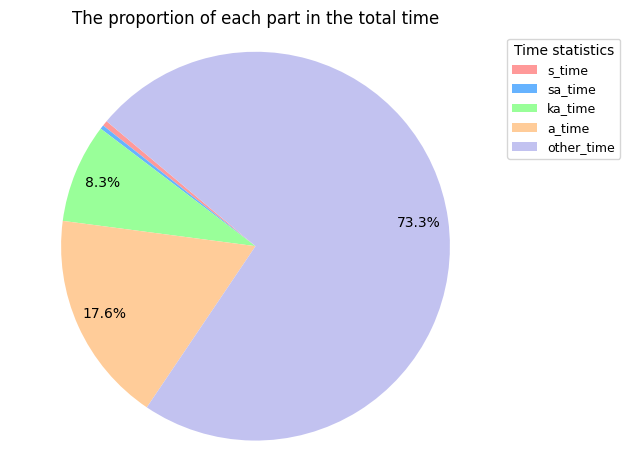

In [65]:
import matplotlib.pyplot as plt

# 时间统计数据
time_stats = {
    's_time': 1.796548843383789,
    'sa_time': 1.326596975326538,
    'wight_time': 0.0,
    'ka_time': 33.054537296295166,
    'a_time': 70.60850167274475,
    'comp_time': 0.0,
    'comp_k_s_time': 0.0,
    'total_time': 400.392245054245
}

# 计算各部分占total_time的比例
total_time = time_stats['total_time']
data = {
    key: value for key, value in time_stats.items() if value > 0 and key != 'total_time'
}

# 将未列出的部分归入“其他时间”
other_time = total_time - sum(data.values())
if other_time > 0:
    data['other_time'] = other_time

# 绘制扇形统计图
labels = data.keys()
sizes = data.values()

# 设置比较浅的颜色
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']


# 自定义百分比显示
def func(pct):
    return f'{pct:.1f}%' if pct > 1 else ''  # 设定阈值


# 绘制饼图
wedges, texts, autotexts = plt.pie(sizes, labels=None, autopct=lambda pct: func(pct),
                                   startangle=140, colors=colors, pctdistance=0.85,
                                   textprops=dict(color="black"))

plt.axis('equal')  # 使饼图为圆形
plt.title('The proportion of each part in the total time')

# 添加图例并调整位置和字体大小
plt.legend(labels, loc='upper left', title="Time statistics", title_fontsize='10', fontsize='9', bbox_to_anchor=(1, 1))

plt.tight_layout()  # 自动调整布局以避免重叠
plt.show()
